In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from src.layers.flow import get_mask, MaskedLinear

In [2]:
import torch
torch.linspace(1.0, 1e-5, 20)

tensor([1.0000e+00, 9.4737e-01, 8.9474e-01, 8.4211e-01, 7.8948e-01, 7.3684e-01,
        6.8421e-01, 6.3158e-01, 5.7895e-01, 5.2632e-01, 4.7369e-01, 4.2106e-01,
        3.6843e-01, 3.1580e-01, 2.6317e-01, 2.1053e-01, 1.5790e-01, 1.0527e-01,
        5.2641e-02, 1.0000e-05])

1152


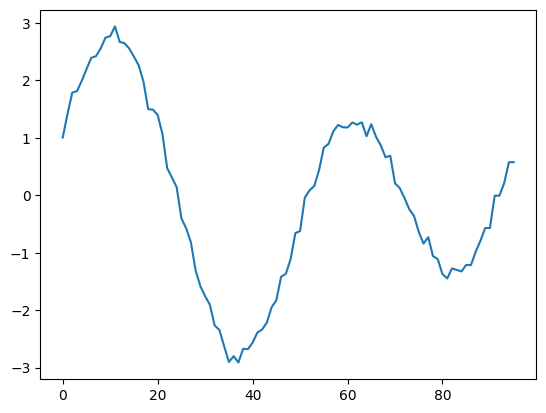

In [14]:
import torch
import matplotlib.pyplot as plt
from torchdiffeq import  odeint
import numpy.random as npr
import numpy as np

# ntotal = 1000
# nsample = 100
# t0_idx = npr.multinomial(1, [1. / (ntotal - 2. * nsample)] * (ntotal - int(2 * nsample)))
# print(t0_idx)
# t0_idx = np.argmax(t0_idx) + nsample
# t0_idx

t = torch.linspace(0, 24 * torch.pi, 1152).float()
data = torch.cos(t) + 2 * torch.sin(t * 2) + torch.randn_like(t) * 0.1
print(96*12)
plt.plot(data[:96])


In [ ]:
a = torch.randn(10,)

()

In [37]:
num_samples = 100
t = torch.linspace(0, 4 * torch.pi, 200).float()
curves = []
labels = []
for _ in range(num_samples):

    a = torch.rand(1).item() * 0.5  # Initial radius
    b = torch.rand(1).item() * 0.2  # Growth rate

    direction = torch.randint(0, 2, (1,)).item()  # 0=clockwise, 1=ccw

    # theta = torch.linspace(0, 4 * torch.pi, self.seq_len)  # Two full rotations
    r = a + b * t
    if direction == 0:
        x = r * torch.cos(t)
        y = r * torch.sin(t)
    else:
        x = -r * torch.cos(t)
        y = r * torch.sin(t)

    x += torch.randn_like(x) * 0.01
    y += torch.randn_like(y) * 0.01

    curve = torch.stack([x, y], dim=1)
    curves.append(curve)
    labels.append(direction)
data, class_cond = torch.stack(curves), torch.tensor(labels)
print(data.shape)
print(class_cond.shape)

torch.Size([100, 200, 2])
torch.Size([100])


tensor([ 36,  24, 106,  64,  15,  43,  61,  25,  63,  75])
tensor([ 86,  74, 156, 114,  65,  93, 111,  75, 113, 125])


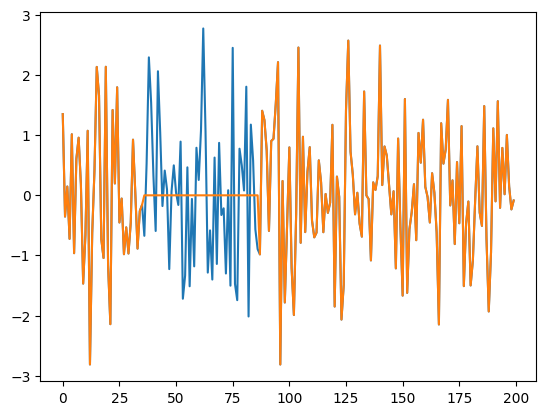

In [95]:
x = torch.randn(1000, 200, 2)
mask = torch.ones(1000, 200, 2)
total_seq_len=mask.shape[1]
delta = 50
rand_start = torch.randint(0, total_seq_len-delta, (1000,))
print(rand_start[:10])
max_delta = 10
# delta = (torch.rand(1000, device=x.device) * (max_delta + 1)).long()
end = rand_start + delta
print(end[:10])

# 生成时间步索引并比较生成布尔掩码
t = torch.arange(200, device=x.device).view(1, -1)  # 形状 [1, 200]
mask_2d = (t >= rand_start.view(-1, 1)) & (t <= end.view(-1, 1))  # 形状 [1000, 200]
mask_3d = mask_2d.unsqueeze(-1).expand_as(mask)
(~mask_3d) * x
plt.plot(x[0, :, 0])
plt.plot(((~mask_3d) * x)[0, :, 0])